# Sensitivity to the number of eofs retained in training: 

In [1]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

In [3]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils_kb as limkb
import LIM_building as limbuild

sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [4]:
def get_title_strings(var,exp_setup,forecast):
    if 'cmip6' in exp_setup['train_dsource']: 
        tcmip='CMIP6'
    elif 'era' in exp_setup['train_dsource']:
        tcmip=''
    elif 'satellite' in exp_setup['train_dsource']: 
        tcmip=''
    elif 'lme' in exp_setup['train_dsource']: 
        tcmip=''
    else: 
        tcmip='CMIP5'

    if 'cmip6' in exp_setup['valid_dsource']: 
        vcmip='CMIP6'
    elif 'era' in exp_setup['valid_dsource']:
        vcmip=''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vcmip=''
    elif 'lme' in exp_setup['valid_dsource']: 
        vcmip=''
    else: 
        vcmip='CMIP5'

    # start_tim = exp_setup['nyears_startvalid']
    # end_tim = exp_setup['nyears_startvalid']+(exp_setup['nyearsvalid']*12)
    valid_yrs_str = (str(forecast['var_dict_valid'][var]['time'][0])[:4]+'_'+
                     str(forecast['var_dict_valid'][var]['time'][-1])[:4])

    if 'hist' in exp_setup['train_dsource']:
        texp = 'Historical'
    elif 'lm' in exp_setup['train_dsource']: 
        texp = 'LM'
    elif 'ssp585' in exp_setup['train_dsource']: 
        texp = 'SSP585'
    elif 'era5' in exp_setup['train_dsource']: 
        texp = 'ERA5'
    elif 'satellite' in exp_setup['train_dsource']: 
        texp = 'Satellite'
    elif 'lme' in exp_setup['train_dsource']: 
        texp = 'LME'

    if 'hist' in exp_setup['valid_dsource']:
        vexp = 'Historical'
    elif 'lm' in exp_setup['valid_dsource']: 
        vexp = 'LM'
    elif 'ssp585' in exp_setup['valid_dsource']: 
        vexp = 'SSP585'
    elif 'era5' in exp_setup['valid_dsource']: 
        vexp = 'ERA5'
    elif 'satellite' in exp_setup['valid_dsource']: 
        vexp = 'Satellite'
    elif 'lme' in exp_setup['valid_dsource']: 
        vexp = 'LME'

    if 'cesm2' in exp_setup['train_dsource']:
        tmod = 'CESM2'
    elif 'mpi' in exp_setup['train_dsource']: 
        tmod = 'MPI'
    elif 'gfdl' in exp_setup['train_dsource']: 
        tmod = 'GFDL'
    elif 'ccsm4' in exp_setup['train_dsource']: 
        tmod = 'CCSM4'
    elif 'era5' in exp_setup['train_dsource']: 
        tmod = ''
    elif 'satellite' in exp_setup['train_dsource']: 
        tmod = ''
    elif 'lme' in exp_setup['train_dsource']: 
        tmod = 'CESM'

    if 'cesm2' in exp_setup['valid_dsource']:
        vmod = 'CESM2'
    elif 'mpi' in exp_setup['valid_dsource']: 
        vmod = 'MPI'
    elif 'gfdl' in exp_setup['valid_dsource']: 
        vmod = 'GFDL'
    elif 'ccsm4' in exp_setup['valid_dsource']: 
        vmod = 'CCSM4'
    elif 'era5' in exp_setup['valid_dsource']: 
        vmod = ''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vmod = ''
    elif 'lme' in exp_setup['valid_dsource']: 
        vmod = 'CESM'

    if exp_setup['Weight'] is True: 
        wt_addin = ' '
    else: 
        wt_addin = '(no area weighting)'

    if exp_setup['detrend'] is True: 
        tr_addin = ' '
    else: 
        tr_addin = ' (trended)'
        
    return tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, wt_addin, tr_addin

In [5]:
def plot_lagged_performance_1var(fig,axs,var,forecast_validation_lags,ar1cast_lags,
                                 tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                 wt_addin, tr_addin):

    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['corr_tot'][:]**2, 
               label='Correlation',linewidth=4)
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['corr_tot'][:-1]**2, 
               label='AR(1) Correlation',linewidth=4, 
               linestyle='--', color='tab:blue',alpha=0.5)

    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['ce_tot'][:],
               label='CE',linewidth=3.0)
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['ce_tot'][:-1],
               label='AR(1) CE',linewidth=3.0, 
               linestyle='--', color='tab:orange', alpha=0.5)

    axs.set_xticks(np.arange(0,11,1))
    axs.set_xticklabels(np.arange(0,11,1),fontsize=12)
    axs.set_ylim(0,1)
    axs.set_xlim(0,8)
    axs.grid(axis='both')
    
    return 

In [6]:
def plot_monthly_performance_1var(fig,axs,var,forecast_validation_lags,ar1cast_lags,
                                  tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                  wt_addin, tr_addin):
    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['gm_rmse'][:], 
               label='LIM',linewidth=3.0, color='purple')
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
               label='AR(1)',linewidth=3.0, linestyle='--', color='purple',alpha=0.5)

    axs.set_xticks(np.arange(0,11,1))
    axs.set_xticklabels(np.arange(0,11,1),fontsize=12)
#    axs.set_ylim(0,0.018)
    axs.set_xlim(0,6)
    axs.grid(axis='both')
    
#    axs.axhline(1.0, color='k', linewidth=2, label='No skill')
    
    return 

In [7]:
plt.rcParams['figure.dpi']=300

In [8]:
ntrunc_list = [5,10,15,20,30,40,50,60,70,80,90,100,150,200,250] # EOF truncation for individual fields (reduced-state space)
ntrunc_sic_list = [5,10,15,20,30,40,50,60,70,80,90,100,150,200,250]
#nmodes = 15 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 20
nmodes_sic_list = [5,10,15,20,30,40,50,60,70,80,90,100,150,200]
#modes_sic = 20

mo='all'
#mo=0
lags = [1,2,3,4,5,6,7,8]

#model = 'satellite'
#model = 'cmip6_mpi_hist'
#model = 'era5'
model = 'cesm_lme'

train_length = 800
yr_labels = 200

# forecast lead time in months that defines the LIM training
tau = 1

# variables to include in the LIM (note "vars" is a Python command)
limvars = ['tas','psl','zg','tos','sit','sic']
#limvars = ['sic']

data_dir = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/'

In [9]:
rmse_sic_is = np.zeros((len(ntrunc_list),len(lags)+1))
rmse_sic_os = np.zeros((len(ntrunc_list),len(lags)+1))

rmse_ar1_sic_is = np.zeros((len(ntrunc_list),len(lags)))
rmse_ar1_sic_os = np.zeros((len(ntrunc_list),len(lags)))

for n,ntrunc in enumerate(ntrunc_list):
    print('Working on '+(" + ").join(limvars))
    var = limvars[0]
#     var_names = (str(ntrunc)+"_").join(limvars)+str(nmodes_sic_list[n])
    
    folder = 'last_millennium/'
    filename_os = ('LIMcast_cesm_lme_002_ntrain_850_1650_cesm_lme_validy_1651_1850_'+
                   'tas'+str(ntrunc)+'L40_psl'+str(ntrunc)+'L40_zg'+str(ntrunc)+'L40_'+
                   'tos'+str(ntrunc)+'L40_sit'+str(ntrunc)+'L40_sic'+str(ntrunc)+'L40_20211113.pkl')
    filename_is = ('LIMcast_cesm_lme_002_ntrain_850_1650_cesm_lme_validy_0851_1050_'+
                   'tas'+str(ntrunc)+'L40_psl'+str(ntrunc)+'L40_zg'+str(ntrunc)+'L40_'+
                   'tos'+str(ntrunc)+'L40_sit'+str(ntrunc)+'L40_sic'+str(ntrunc)+'L40_20211113.pkl')

    print('Loading '+data_dir+folder+filename_is)

    experiment_os =  pickle.load(open(data_dir+folder+filename_os, 'rb'))
    experiment_is =  pickle.load(open(data_dir+folder+filename_is, 'rb'))
    
    LIMd_is = experiment_is['LIMd']
    exp_setup_is = experiment_is['forecast']['exp_setup']
    forecast_is = experiment_is['forecast']
    forecast_validation_lags_is = experiment_is['forecast_validation_lags']
    ar1cast_lags_is = experiment_is['ar1cast_lags']
    
    exp_setup_os = experiment_os['forecast']['exp_setup']
    forecast_os = experiment_os['forecast']
    forecast_validation_lags_os = experiment_os['forecast_validation_lags']
    ar1cast_lags_os = experiment_os['ar1cast_lags']
    
    [tcmip_is, vcmip_is, valid_yrs_str_is, texp_is, 
     vexp_is, tmod_is, vmod_is, wt_addin_is, tr_addin_is] = get_title_strings(var,exp_setup_is,forecast_is)
    [tcmip_os, vcmip_os, valid_yrs_str_os, texp_os, 
     vexp_os, tmod_os, vmod_os, wt_addin_os, tr_addin_os] = get_title_strings(var,exp_setup_os,forecast_os)
    
    rmse_sic_is[n,:] = forecast_validation_lags_is['validation_stats_lags']['sic']['gm_rmse']
    rmse_sic_os[n,:] = forecast_validation_lags_os['validation_stats_lags']['sic']['gm_rmse']
    
    rmse_ar1_sic_is[n,:] = ar1cast_lags_is['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]
    rmse_ar1_sic_os[n,:] = ar1cast_lags_os['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]

Working on tas + psl + zg + tos + sit + sic
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_cesm_lme_validy_0851_1050_tas5L40_psl5L40_zg5L40_tos5L40_sit5L40_sic5L40_20211113.pkl
Working on tas + psl + zg + tos + sit + sic
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_cesm_lme_validy_0851_1050_tas10L40_psl10L40_zg10L40_tos10L40_sit10L40_sic10L40_20211113.pkl
Working on tas + psl + zg + tos + sit + sic
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_cesm_lme_validy_0851_1050_tas15L40_psl15L40_zg15L40_tos15L40_sit15L40_sic15L40_20211113.pkl
Working on tas + psl + zg + tos + sit + sic
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_cesm_lme_validy_0851_1050_tas20L40_psl20L40_zg20L40_tos20L40_sit20L40_sic2

In [25]:
ar1cast_lags_is['validation_stats_ar1_lags']['sic']['gm_rmse']

array([0.06166755, 0.07187482, 0.07455997, 0.075447  , 0.07564522,
       0.07570666, 0.07576854, 0.075782  , 0.        ])

In [29]:
rmse_ar1_sic_is[:,1]

array([0.07363414, 0.07255016, 0.07231405, 0.07223196, 0.07205542,
       0.07201064, 0.07197936, 0.07195242, 0.07193136, 0.07191899,
       0.07191347, 0.07190716, 0.07189793, 0.07187631, 0.07187482])

In [32]:
# colors = ['royalblue', 'darkcyan', 'darkblue','firebrick', 'salmon', 'peru', 'orange',
#           'mediumpurple','m', 'indigo', 'k']

#cmap = matplotlib.cm.get_cmap('plasma_r')
#cmap = matplotlib.cm.get_cmap('viridis_r')
cmap = matplotlib.cm.get_cmap('Blues_r')

move = 0.7/3
colors = [cmap(i) for i in np.arange(0.1,1,move)]

In [33]:
np.argmin(rmse_sic_os[:,1]), np.argmin(rmse_sic_os[:,2]), np.argmin(rmse_sic_os[:,3])

(13, 12, 11)

In [34]:
ntrunc_list[13], ntrunc_list[12], ntrunc_list[11]

(200, 150, 100)

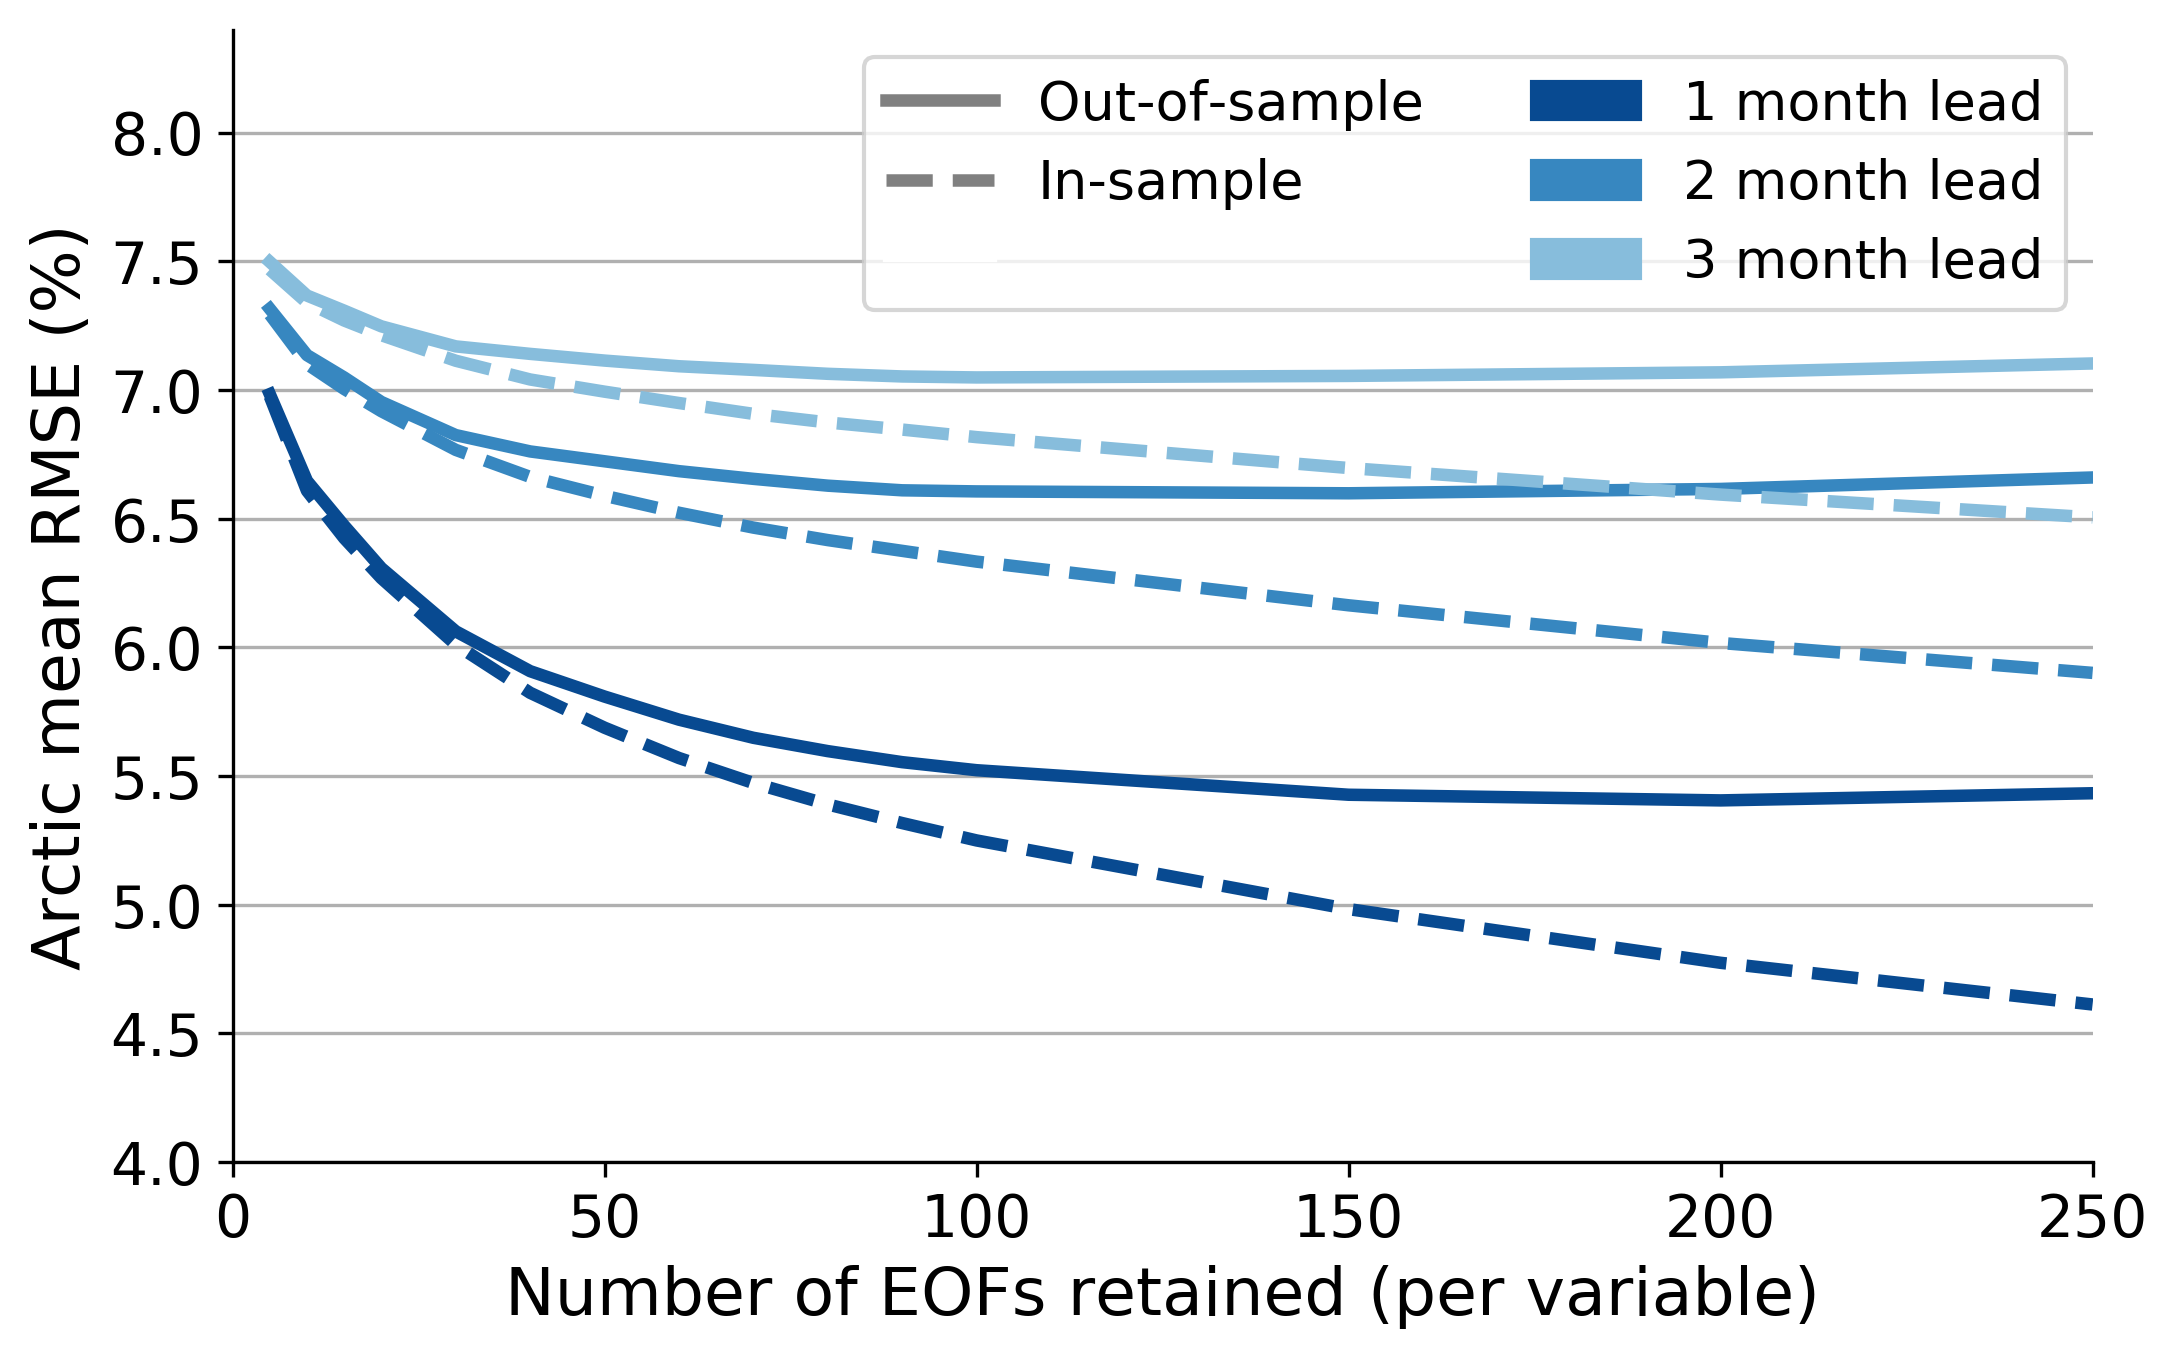

In [35]:
fig,ax = plt.subplots(1,1,figsize=(8,5))

ax.plot(np.array(ntrunc_list), (rmse_sic_is[:,1])*100, linewidth=3,color=colors[0], linestyle='--')
ax.plot(np.array(ntrunc_list),(rmse_sic_os[:,1])*100, linewidth=3,color=colors[0])

ax.plot(np.array(ntrunc_list), (rmse_sic_is[:,2])*100, linewidth=3,color=colors[1], linestyle='--')
ax.plot(np.array(ntrunc_list),(rmse_sic_os[:,2])*100, linewidth=3,color=colors[1])

ax.plot(np.array(ntrunc_list), (rmse_sic_is[:,3])*100, linewidth=3,color=colors[2], linestyle='--')
ax.plot(np.array(ntrunc_list),(rmse_sic_os[:,3])*100, linewidth=3,color=colors[2])
    
    
ax.plot(np.arange(-2,-1,0.1),np.arange(-2,-1,0.1),color='gray',linewidth=3, label='Out-of-sample')
ax.plot(np.arange(-2,-1,0.1),np.arange(-2,-1,0.1),color='gray',linewidth=3, linestyle='--', label='In-sample')
ax.plot(np.arange(-2,-1,0.1),np.arange(-2,-1,0.1),color='white',label=' ')
ax.fill_between(np.arange(-2,-1,0.1),np.arange(-2,-1,0.1),color=colors[0],label='1 month lead')
ax.fill_between(np.arange(-2,-1,0.1),np.arange(-2,-1,0.1),color=colors[1],label='2 month lead')
ax.fill_between(np.arange(-2,-1,0.1),np.arange(-2,-1,0.1),color=colors[2], label='3 month lead')

ax.set_xlim(0,250)
ax.set_ylim(4,8.4)
#ax[0].legend(bbox_to_anchor=[1,1],fontsize=14)
ax.set_ylabel('Arctic mean RMSE (%)', fontsize=16)
ax.set_xlabel('Number of EOFs retained (per variable)', fontsize=16)
#ax.set_xticklabels(np.flip(yr_labels), fontsize=14)
#ax.set_title('In Sample Validation', fontsize=18)
ax.tick_params(labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.grid(axis='y')

plt.legend(loc='upper right', ncol=2, fontsize=13)

savename = './figures/LIM_neofs_skill.png'
plt.savefig(savename)

In [36]:
rmse_ar1_sic_is.shape

(15, 8)

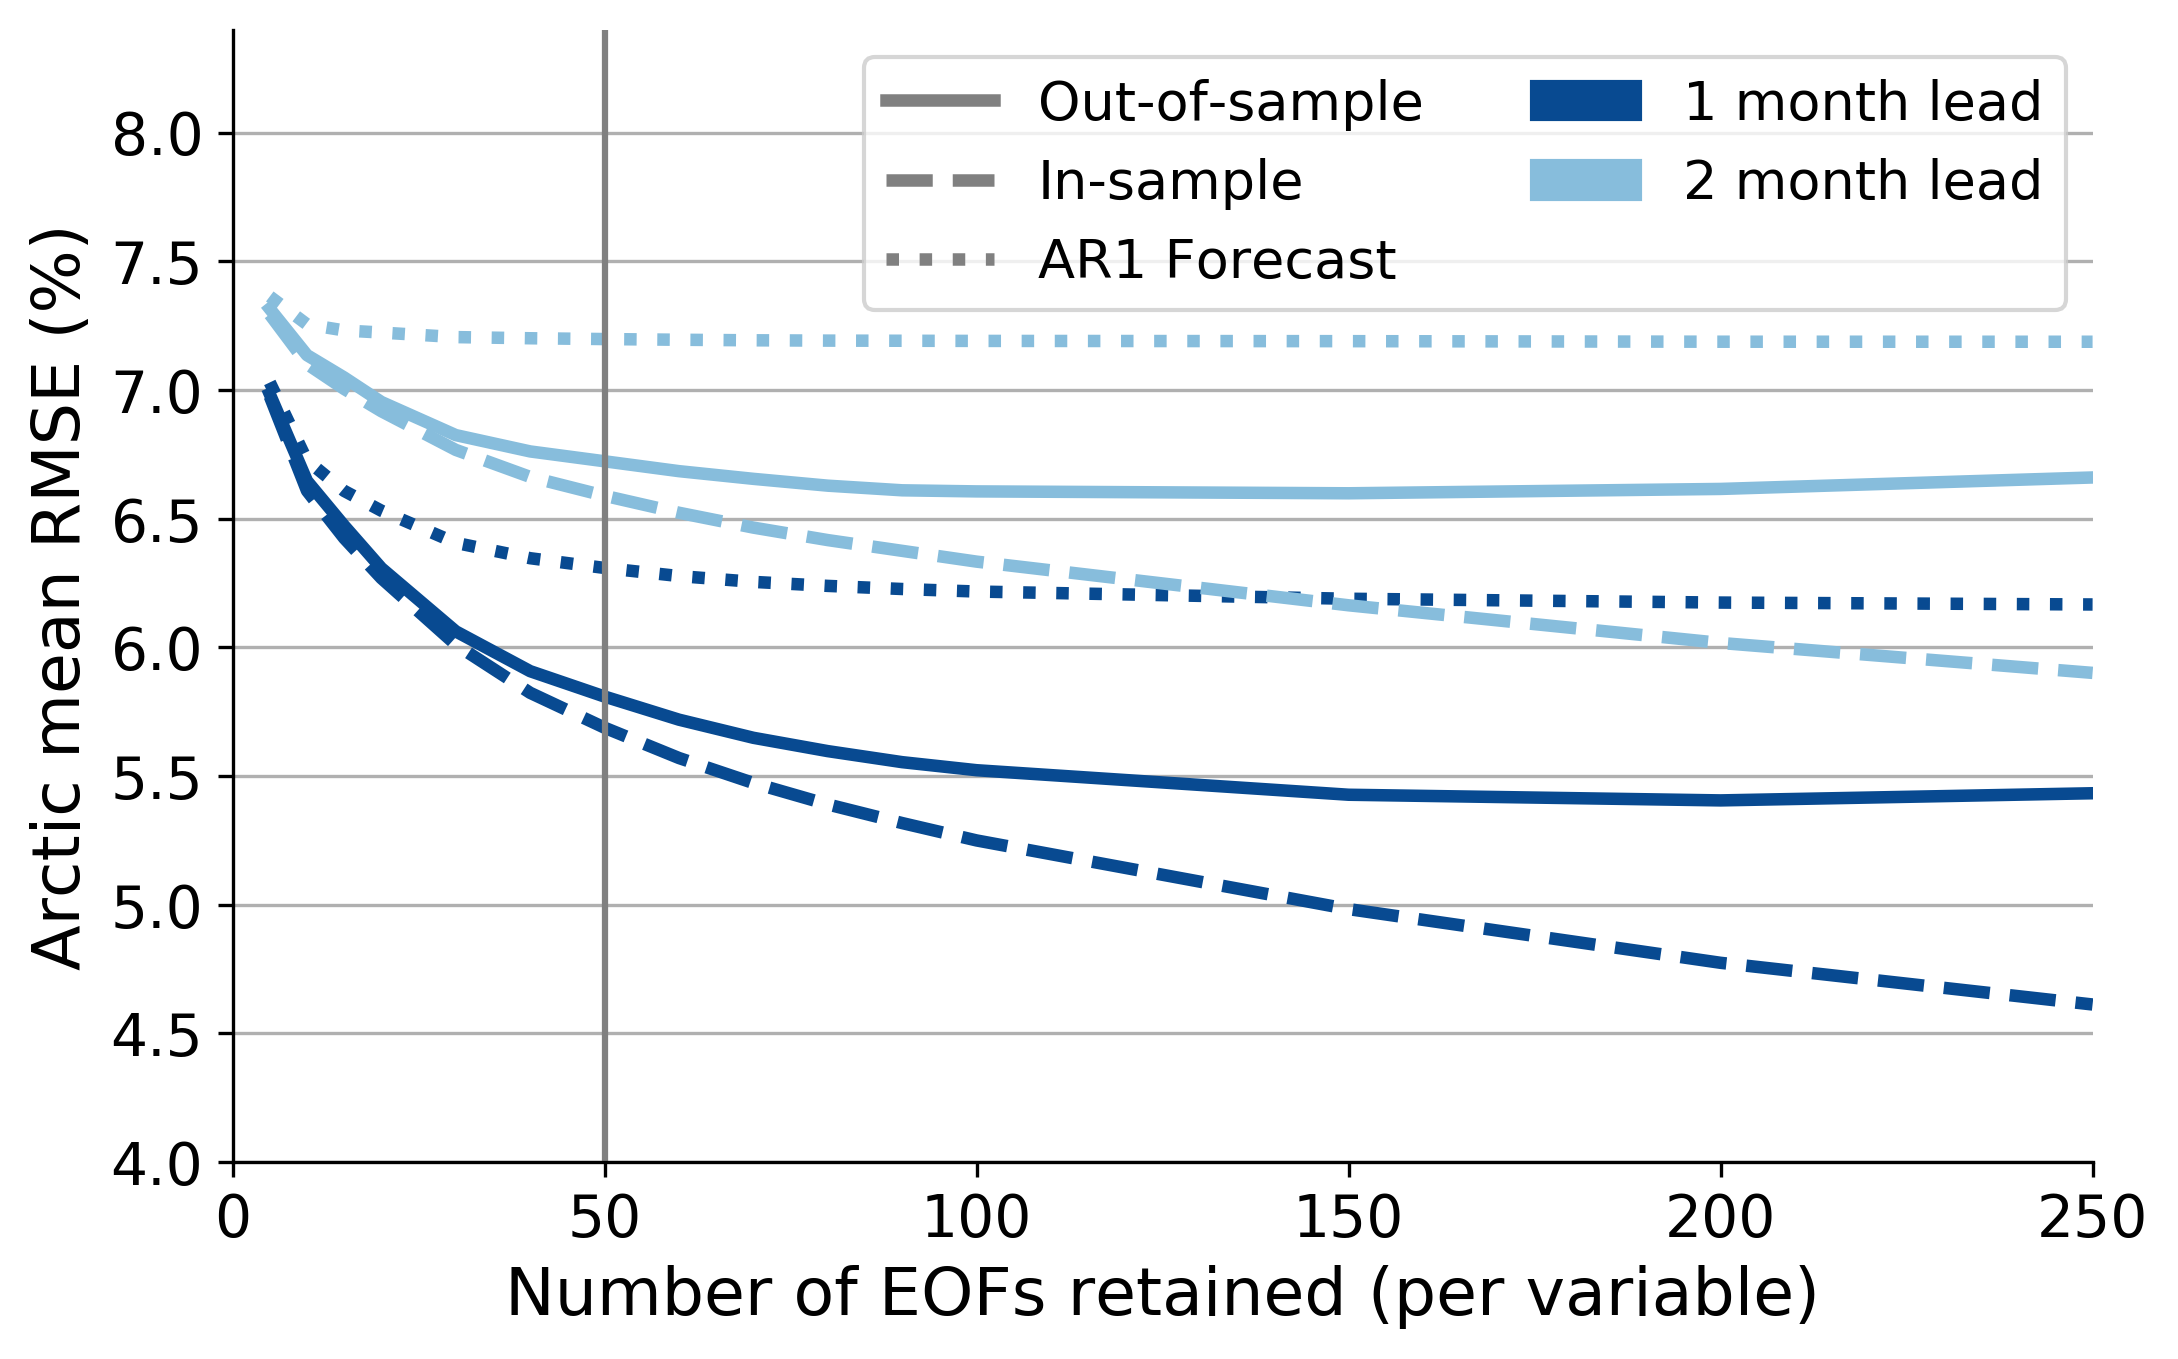

In [45]:
fig,ax = plt.subplots(1,1,figsize=(8,5))

ax.plot(np.array(ntrunc_list), (rmse_sic_is[:,1])*100, linewidth=3,color=colors[0], linestyle='--')
ax.plot(np.array(ntrunc_list),(rmse_sic_os[:,1])*100, linewidth=3,color=colors[0])
ax.plot(np.array(ntrunc_list), (rmse_ar1_sic_is[:,0])*100, linewidth=3,color=colors[0], linestyle='dotted')

ax.plot(np.array(ntrunc_list), (rmse_sic_is[:,2])*100, linewidth=3,color=colors[2], linestyle='--')
ax.plot(np.array(ntrunc_list),(rmse_sic_os[:,2])*100, linewidth=3,color=colors[2])
ax.plot(np.array(ntrunc_list), (rmse_ar1_sic_is[:,1])*100, linewidth=3,color=colors[2], linestyle='dotted')

# ax.plot(np.array(ntrunc_list), (rmse_sic_is[:,3])*100, linewidth=3,color=colors[2], linestyle='--')
# ax.plot(np.array(ntrunc_list),(rmse_sic_os[:,3])*100, linewidth=3,color=colors[2])
# ax.plot(np.array(ntrunc_list), (rmse_ar1_sic_is[:,2])*100, linewidth=3,color=colors[2], linestyle='dashdot')    
    
ax.plot(np.arange(-2,-1,0.1),np.arange(-2,-1,0.1),color='gray',linewidth=3, label='Out-of-sample')
ax.plot(np.arange(-2,-1,0.1),np.arange(-2,-1,0.1),color='gray',linewidth=3, linestyle='--', label='In-sample')
ax.plot(np.arange(-2,-1,0.1),np.arange(-2,-1,0.1),color='gray',linewidth=3, linestyle='dotted', label='AR1 Forecast')
# ax.plot(np.arange(-2,-1,0.1),np.arange(-2,-1,0.1),color='white',label=' ')
ax.fill_between(np.arange(-2,-1,0.1),np.arange(-2,-1,0.1),color=colors[0],label='1 month lead')
ax.fill_between(np.arange(-2,-1,0.1),np.arange(-2,-1,0.1),color=colors[2],label='2 month lead')
#ax.fill_between(np.arange(-2,-1,0.1),np.arange(-2,-1,0.1),color=colors[2], label='3 month lead')

ax.set_xlim(0,250)
ax.set_ylim(4,8.4)
#ax[0].legend(bbox_to_anchor=[1,1],fontsize=14)
ax.set_ylabel('Arctic mean RMSE (%)', fontsize=16)
ax.set_xlabel('Number of EOFs retained (per variable)', fontsize=16)
#ax.set_xticklabels(np.flip(yr_labels), fontsize=14)
#ax.set_title('In Sample Validation', fontsize=18)
ax.tick_params(labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.axvline(50,color='gray')

plt.grid(axis='y')

plt.legend(loc='upper right', ncol=2, fontsize=13)

# savename = './figures/LIM_neofs_skill.png'
# plt.savefig(savename)

In [18]:
cmap = matplotlib.cm.get_cmap('Blues_r')

move = 0.9/len(ntrunc_list)
colors = [cmap(i) for i in np.arange(0.1,1,move)]

In [19]:
rmse_sic_is[nt,:].shape, np.arange(0,8,1).shape

((9,), (8,))

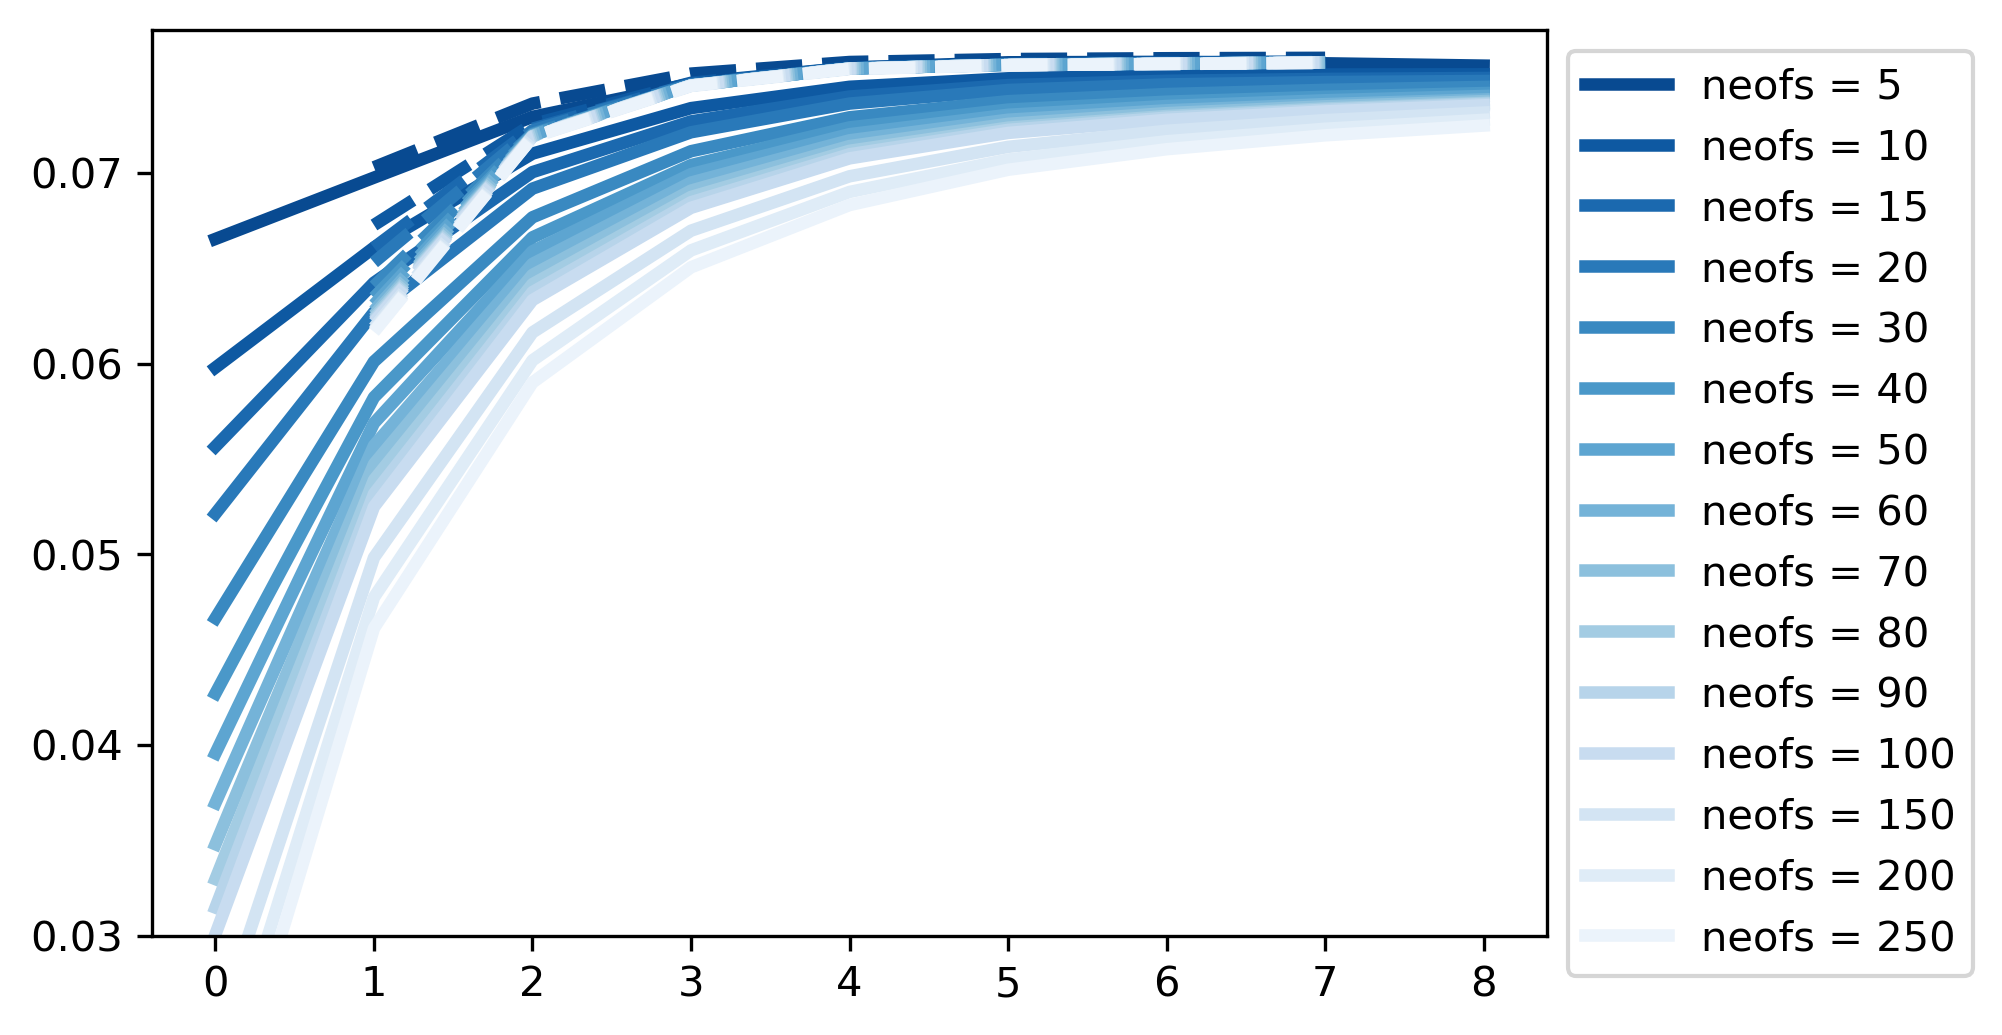

In [20]:
nt = 5
for nt,ntrunc in enumerate(ntrunc_list): 
    plt.plot(np.arange(0,9,1),rmse_sic_is[nt,:], color=colors[nt], linewidth=3,label='neofs = '+str(ntrunc))
    plt.plot(np.arange(1,8,1),rmse_ar1_sic_is[nt,:-1],color=colors[nt], linewidth=3, linestyle='--')
    plt.ylim(0.03,0.0775)

plt.legend(bbox_to_anchor=[1,1])

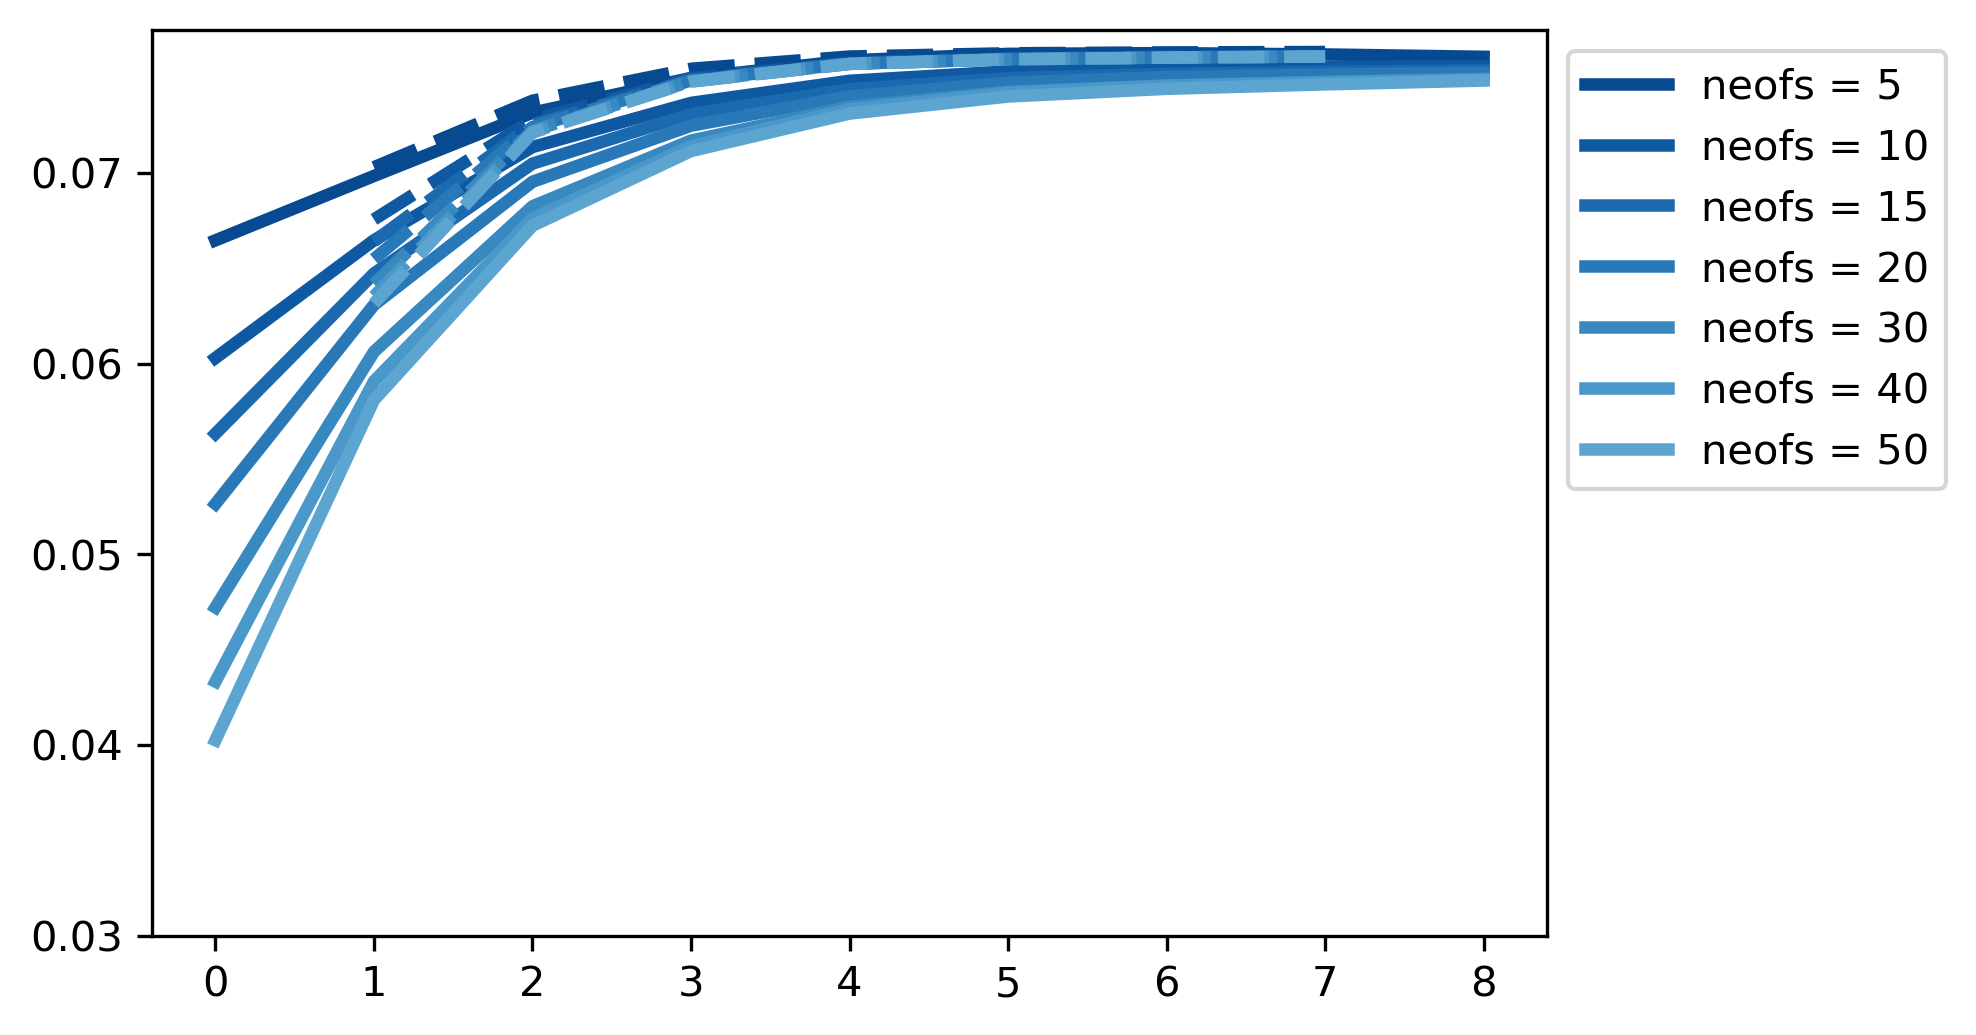

In [21]:
nt = 5
for nt,ntrunc in enumerate([5,10,15,20,30,40,50]): 
    plt.plot(np.arange(0,9,1),rmse_sic_os[nt,:], color=colors[nt], linewidth=3,label='neofs = '+str(ntrunc))
    plt.plot(np.arange(1,8,1),rmse_ar1_sic_os[nt,:-1],color=colors[nt], linewidth=3, linestyle='--')
    plt.ylim(0.03,0.0775)

plt.legend(bbox_to_anchor=[1,1])
#plt.xlim(1,6)

TypeError: 'numpy.int64' object is not iterable

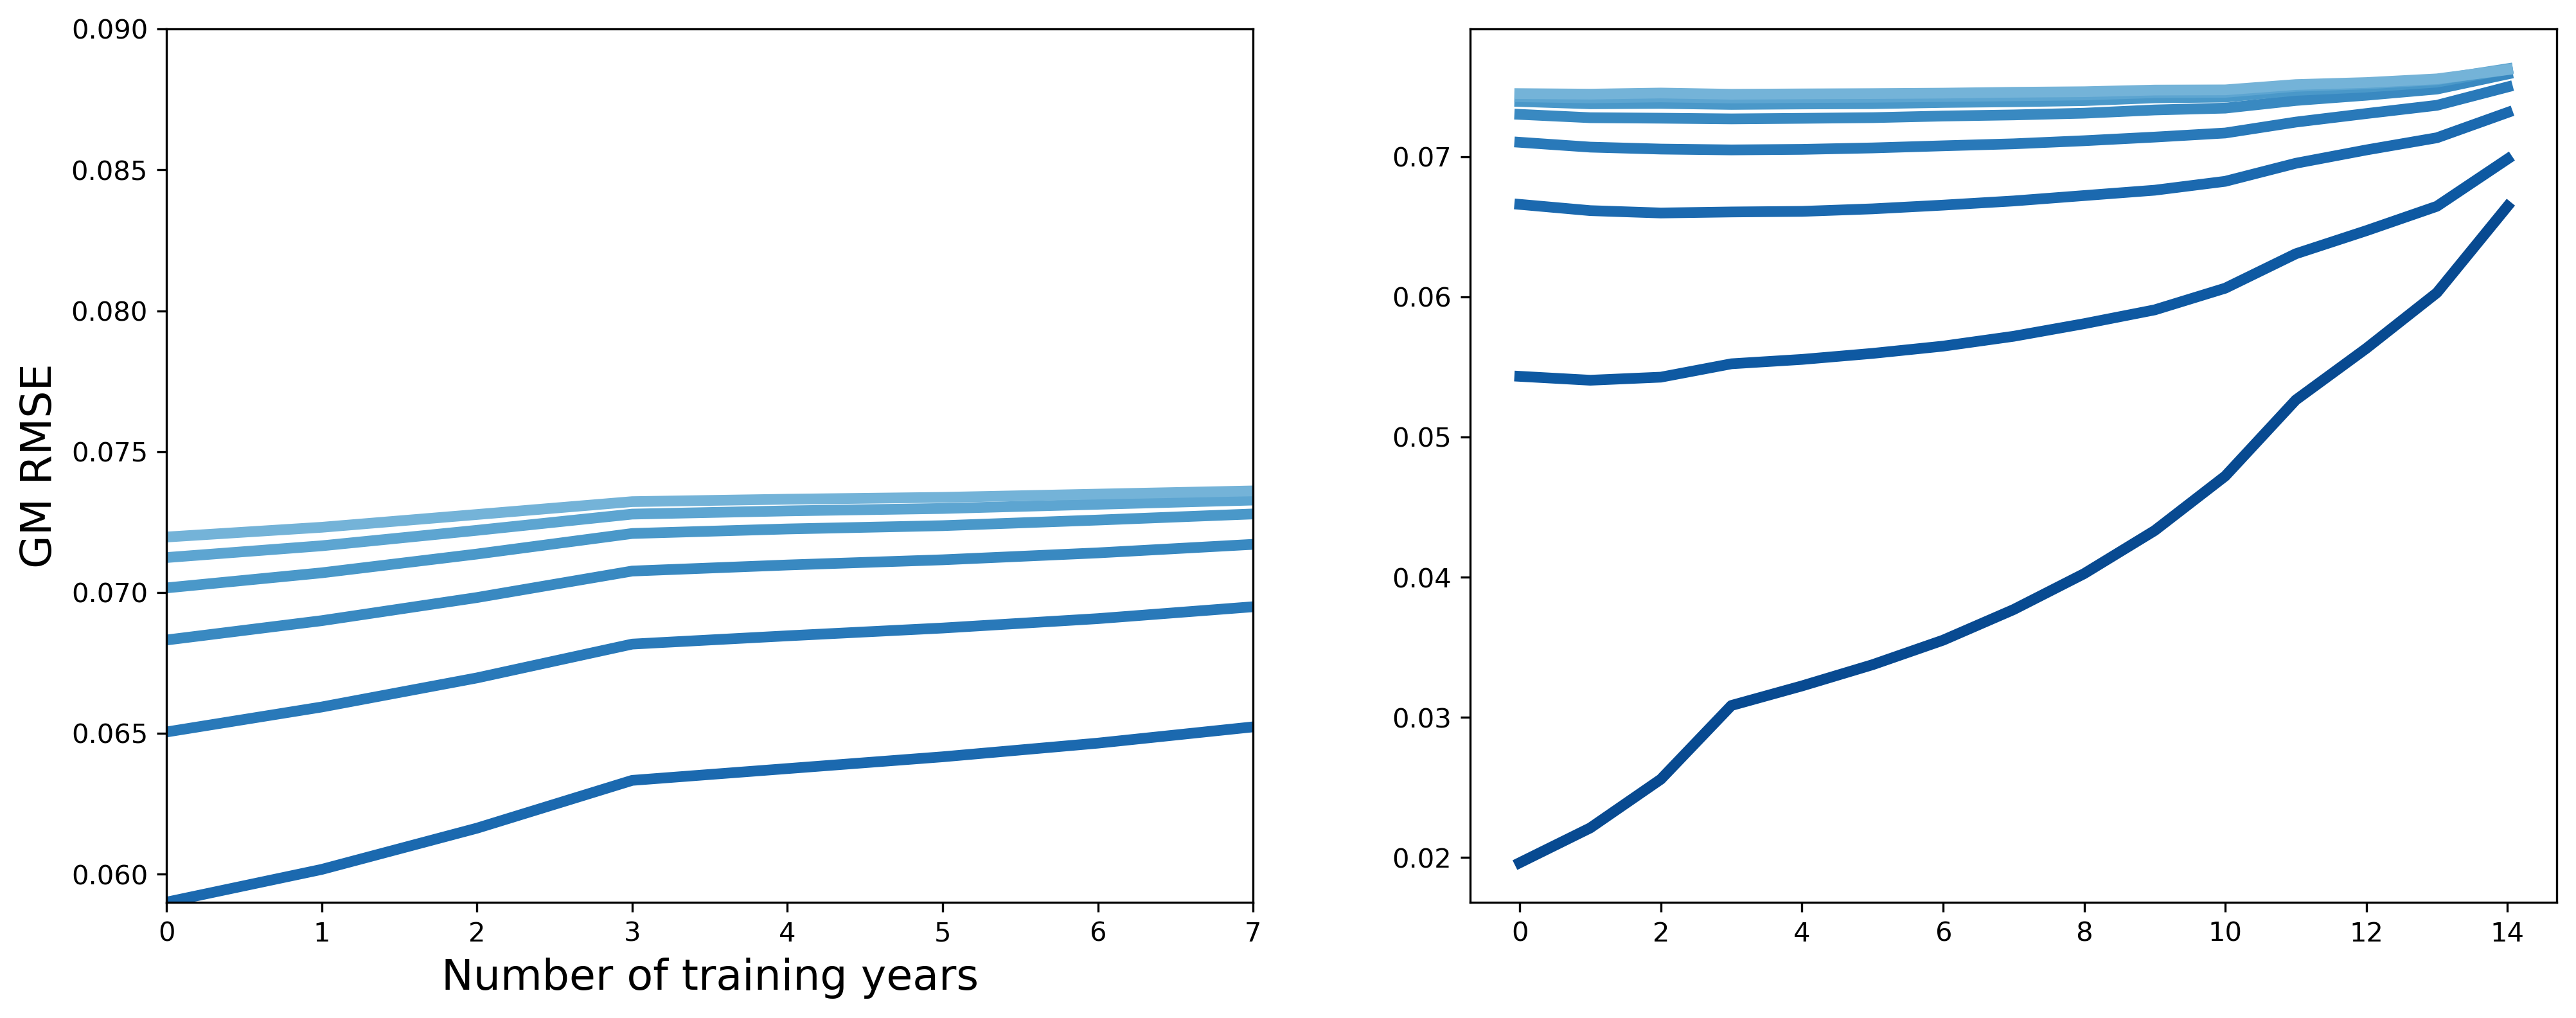

In [22]:
fig,axs = plt.subplots(1,2,figsize=(16,6))
ax = axs.flatten()

for i,lag in enumerate(lags):
    ax[0].plot(np.flip(rmse_sic_is[:,i]), label='lag '+str(lag), linewidth=4,color=colors[i])
    ax[1].plot(np.flip(rmse_sic_os[:,i]), label='lag '+str(lag), linewidth=4,color=colors[i])
    
ax[0].set_xlim(0,7)
ax[0].set_ylim(0.059,0.09)
#ax[0].legend(bbox_to_anchor=[1,1],fontsize=14)
ax[0].set_ylabel('GM RMSE', fontsize=16)
ax[0].set_xlabel('Number of training years', fontsize=16)
ax[0].set_xticklabels(np.flip(yr_labels), fontsize=14)
ax[0].set_title('In Sample Validation', fontsize=18)
ax[0].tick_params(labelsize=14)


ax[1].set_xlim(0,7)
ax[1].set_ylim(0.059,0.09)
ax[1].legend(bbox_to_anchor=[1,1],fontsize=14)
ax[1].set_ylabel('GM RMSE', fontsize=16)
ax[1].set_xlabel('Number of training years', fontsize=16)
ax[1].set_xticklabels(yr_labels, fontsize=14)
ax[1].set_title('Out of Sample Validation', fontsize=18)
ax[1].tick_params(labelsize=14)

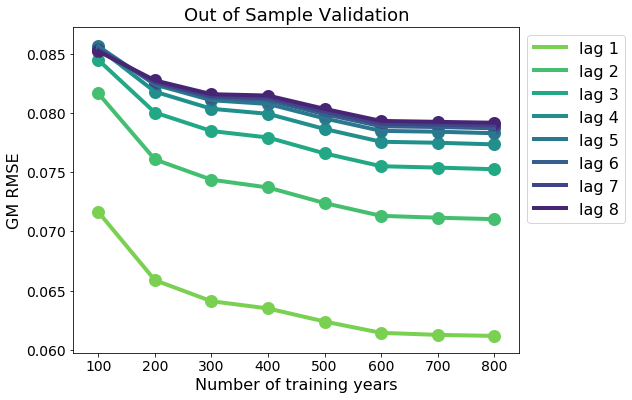

In [47]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

for i,lag in enumerate(lags):
    ax.plot(np.flip(yr_labels),np.flip(rmse_sic_os[:,i]), label='lag '+str(lag), linewidth=4,color=colors[i])
#    ax.scatter(np.flip(yr_labels),np.flip(rmse_sic_os[:,i]), linewidth=3, marker='_', s=1000, color=colors[i])
    ax.scatter(np.flip(yr_labels),np.flip(rmse_sic_os[:,i]), s=100,linewidth=3, color=colors[i])
    
#ax.set_xlim(0,7)
#ax.set_ylim(0.059,0.09)
#ax[0].legend(bbox_to_anchor=[1,1],fontsize=14)
ax.set_ylabel('GM RMSE', fontsize=16)
ax.set_xlabel('Number of training years', fontsize=16)
# ax[0].set_xticklabels(np.flip(yr_labels), fontsize=14)
ax.set_title('Out of Sample Validation', fontsize=18)
ax.tick_params(labelsize=14)
plt.legend(bbox_to_anchor=[1,1],fontsize=16)

In [5]:
# %run run_forecast_LME_neofs_sensitivity_110221.py

# Variance explained by neofs retained: 

In [25]:
mod_folder = ('/home/disk/kalman2/mkb22/SI_LIMs/truncated_data/last_millennium/')
var_explained = {}

for v,var in enumerate(limvars):
    print('Working on '+var)
    var_exp = np.zeros((len(ntrunc_list)))
    for n,ntrunc in enumerate(ntrunc_list):
        mod_filename = (var+'_ntrunc'+str(ntrunc)+'_002_monthall_cesm_lme_latcutoff_40_wtTrue_dtTrue'+
                        '_ntrain_850_1650_20211014.pkl')
        
        trunc_data =  pickle.load(open(mod_folder+mod_filename, 'rb'))
        
        var_exp[n] = trunc_data['var_expl_by_retained']
        
    var_explained[var] = var_exp

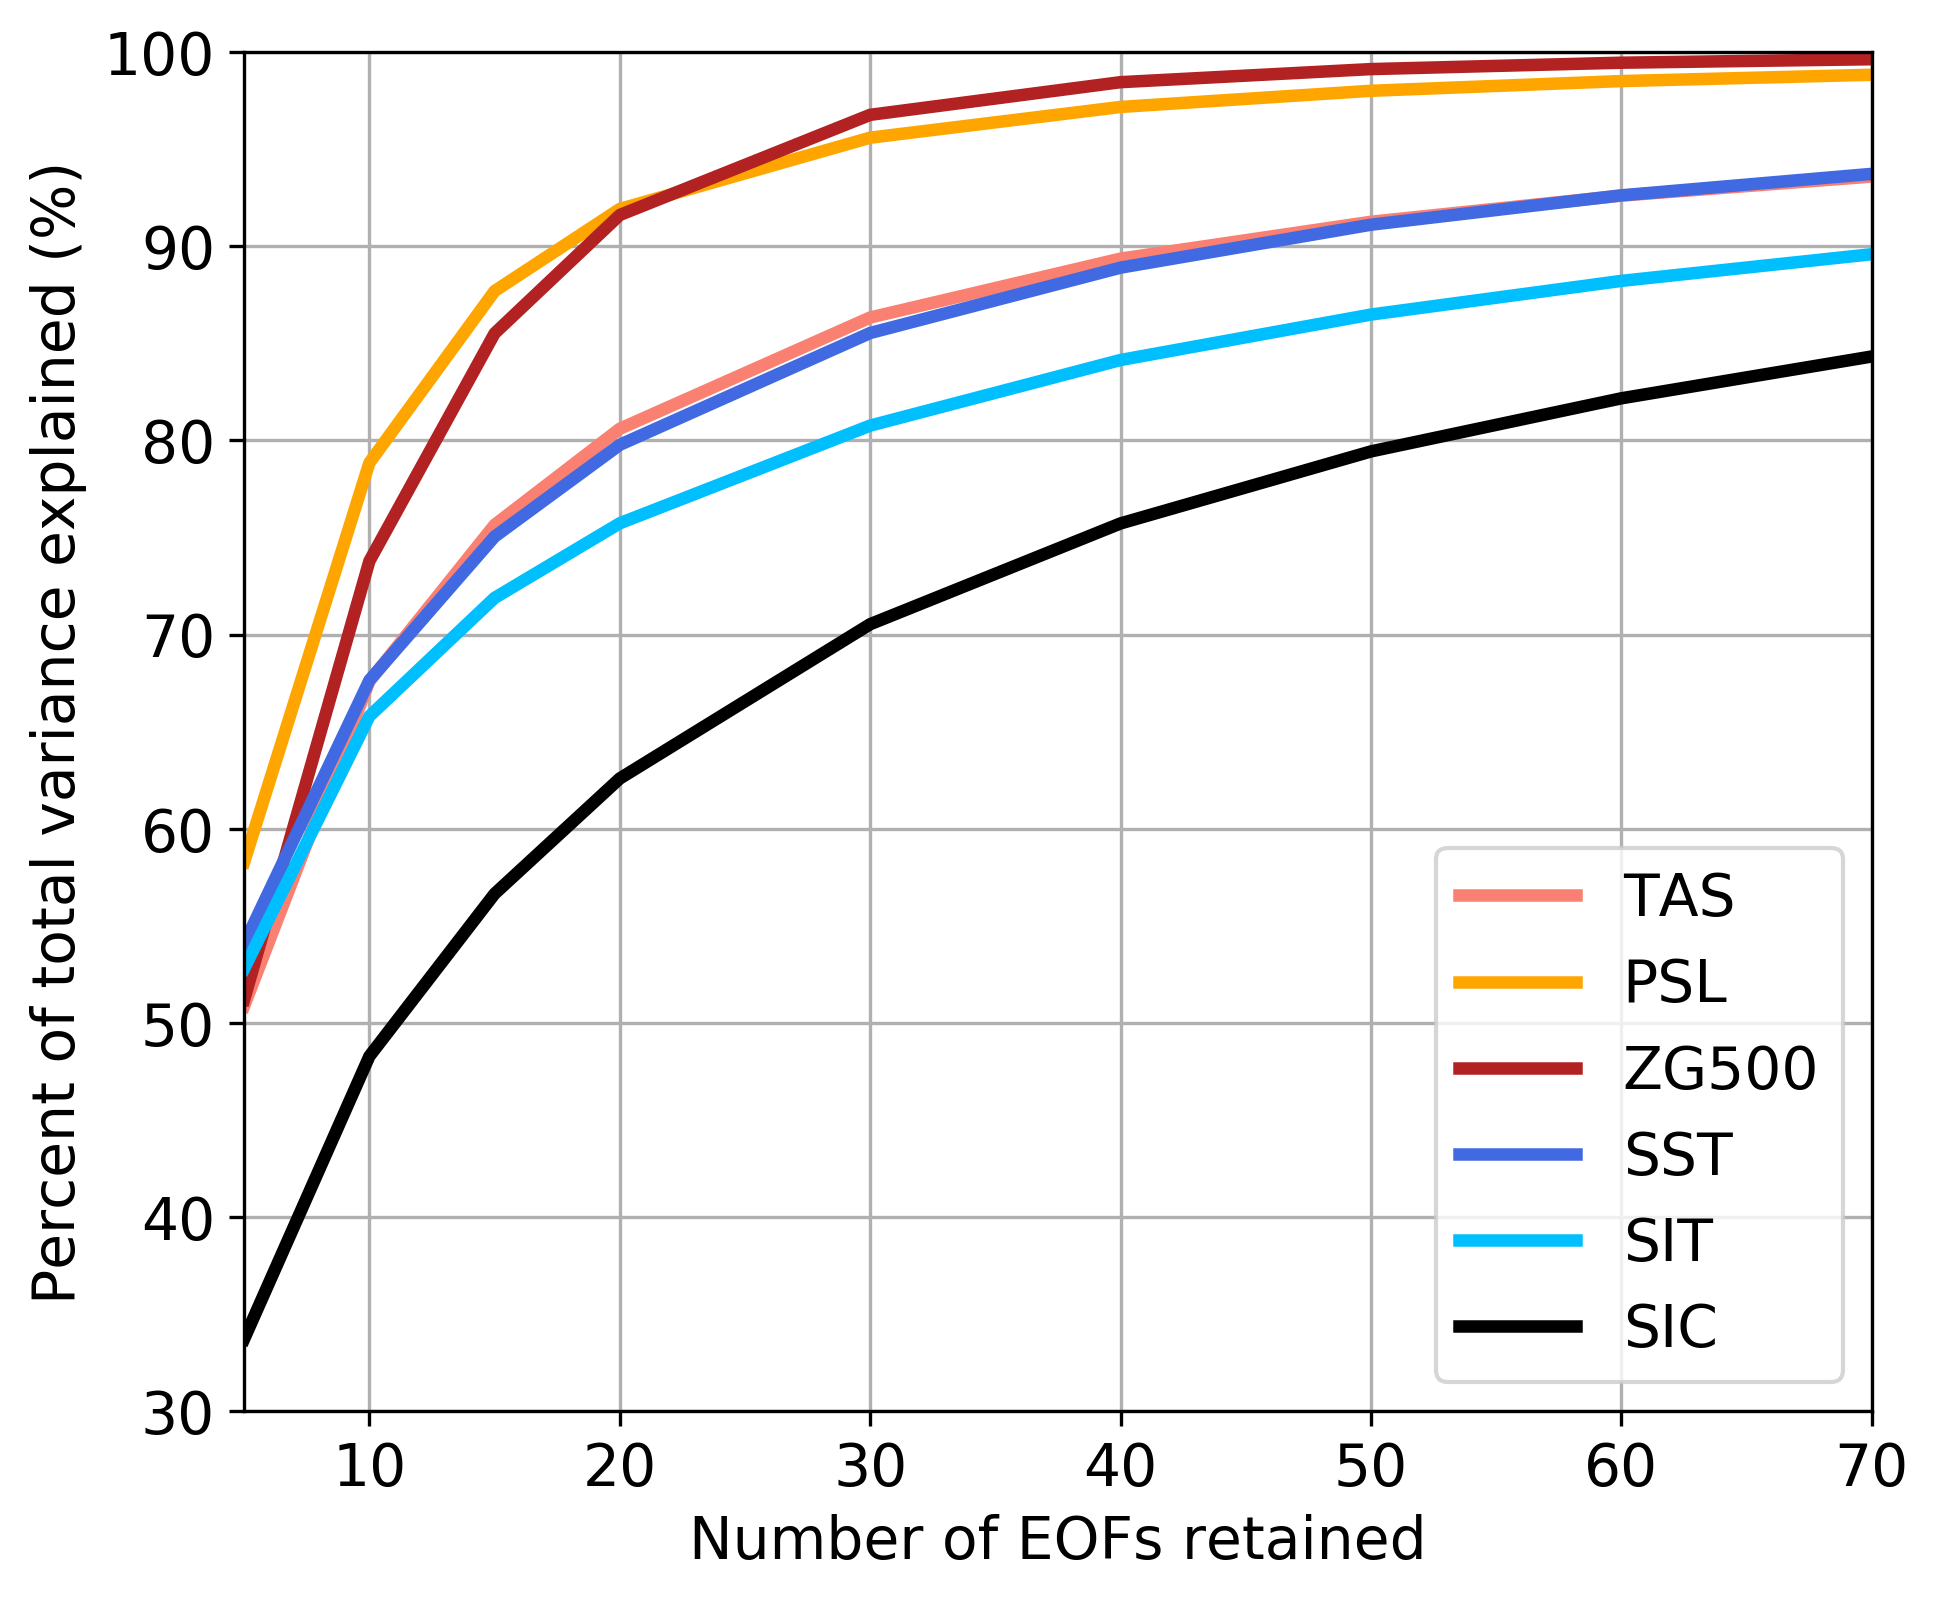

In [32]:
neofs = np.array(ntrunc_list)
fig = plt.figure(figsize=(7,6))

colors = {'tas':'salmon', 
          'psl':'orange',
          'zg':'firebrick',
          'tos':'royalblue',
          'sit':'deepskyblue',
          'sic':'k'}

labels = {'tas':'TAS','psl':'PSL','zg':'ZG500','tos':'SST',
          'sit':'SIT','sic':'SIC'}

for i,var in enumerate(limvars):
    plt.plot(neofs,var_explained[var],label=labels[var],linewidth=3,color=colors[var])
    
#plt.axhline(70,linestyle='--', color='k')
# plt.plot(neofs,var_explained_satellite['sic'],label='sic satellite',
#          linewidth=3,linestyle='--',color='royalblue')

plt.legend(fontsize=14)
plt.xlabel('Number of EOFs retained', fontsize=14)
plt.ylabel('Percent of total variance explained (%)', fontsize=14)
#plt.title('CESM LME (850-1650 CE)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(30,100)
plt.xlim(5,70)
plt.grid(which='major')

savename = './figures/Neofs_var_explained.png'
plt.savefig(savename)